In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("../../Functions")
from GS_waves import select_freq_range, propagation_ew
from abtem.waves import PlaneWave
from Column_matching import (
    Bessel_transform,
    propagation_Bessel,
    match_parameters_Bessel
)
import Generate_structure
from ase.visualize.plot import plot_atoms
from ase.io import read, write
from Complex_Gaussian import(
    Gaussian_function,
    Gaussian_in_focus,
    Gaussian_fitting
)
from Defocus_circle import generate_continious_phase
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

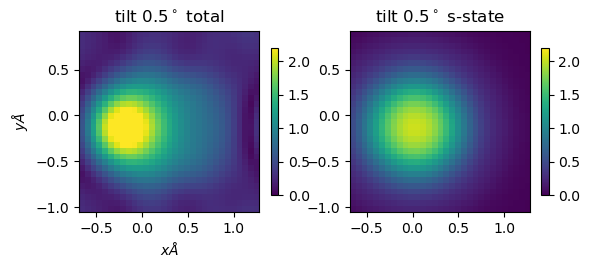

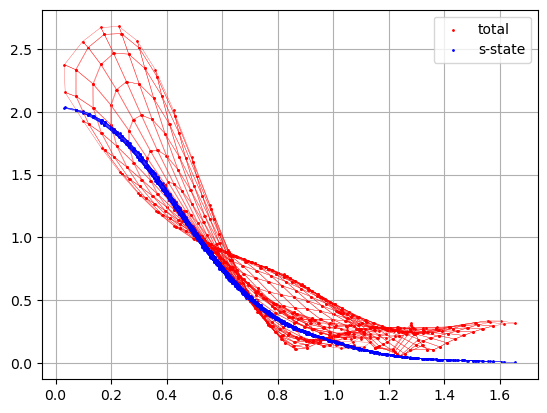

In [2]:
#Parameters to set
gmin = 0; gmax = 2; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
n_repeat = 2
thickness = 20
theta = np.linspace(0, 2*np.pi, 100)
cmap = plt.get_cmap("plasma")
cut_factor = 0.01
krange = np.linspace(gmin+cut_factor, gmax, length)
#Generate isolated structure
tilt_angle = 0.5
structure = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
structure.rotate(tilt_angle, "x")
exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure).array),
                        gmin, gmax, sampling)
m, n = exitwave_all.shape
exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                        (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
m, n = exitwave.shape
coeffs = match_parameters_Bessel(exitwave, sampling, 0.01, 1, method="BFGS")
x0, y0, bg_amp, bg_pha = coeffs
x = np.arange(-(m-1)/2, (m+1)/2, 1)*sampling - x0; y = np.arange(-(n-1)/2, (n+1)/2, 1)*sampling - y0
X, Y = np.meshgrid(x, y); R = np.sqrt(X**2 + Y**2)
results, components = Bessel_transform(exitwave-1, sampling, gmin+cut_factor, gmax, length, 
                                       x0=x0, y0=y0)
plt.subplot(1, 2, 1)
plt.imshow(np.abs(exitwave-1), extent=[x[0], x[-1], y[0], y[-1]], vmin=0, vmax=2.2)
plt.colorbar(shrink=0.4)
plt.xlabel(r"$x\AA$")
plt.ylabel(r"$y\AA$")
plt.title(r"tilt $0.5^\circ$ total")
plt.subplot(1, 2, 2)
plt.imshow(np.abs(components), extent=[x[0], x[-1], y[0], y[-1]], vmin=0, vmax=2.2)
plt.colorbar(shrink=0.4)
#plt.xlabel(r"$x\AA$")
#plt.ylabel(r"$y\AA$")
plt.title(r"tilt $0.5^\circ$ s-state")
#plt.tight_layout()
plt.show()
plt.scatter(R, np.abs(exitwave-1), color='r', s=1, label="total")
plt.plot(R, np.abs(exitwave-1), color='r', linewidth=0.2)
plt.plot(R.T, np.abs(exitwave-1).T, color='r', linewidth=0.2)
plt.scatter(R, np.abs(components), color='b', s=1, label="s-state")
plt.plot(R, np.abs(components), color='b', linewidth=0.2)
plt.plot(R.T, np.abs(components).T, color='b', linewidth=0.2)
plt.legend()
plt.grid()
plt.show()

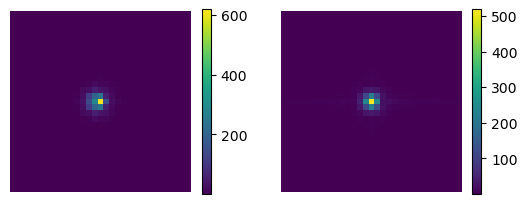

In [14]:
residue = exitwave - 1
res_FT = np.fft.fftshift(np.fft.fft2(residue))
#plt.imshow(np.abs(residue), extent=[x[0], x[-1], y[0], y[-1]])
plt.subplot(1, 2, 1)
plt.imshow(np.abs(res_FT))
plt.axis("off")
plt.colorbar(shrink=0.5)
res_FT = np.fft.fftshift(np.fft.fft2(residue))
proj_FT = np.fft.fftshift(np.fft.fft2(components))
plt.subplot(1, 2, 2)
plt.imshow(np.abs(proj_FT))
plt.axis("off")
plt.colorbar(shrink=0.5)
plt.show()

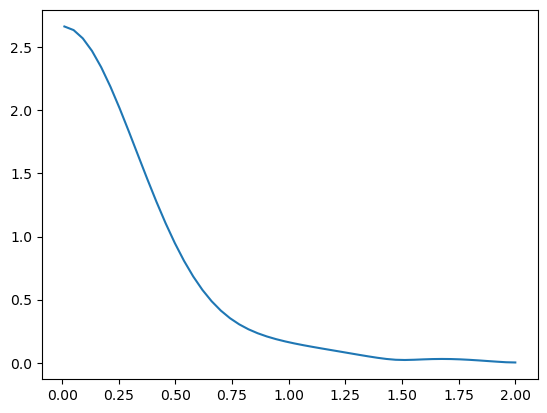

In [6]:
plt.plot(krange, np.abs(results))
plt.show()

In [155]:
np.arange(-(m-1)/2, (m+1)/2, 1).shape

(31,)

100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


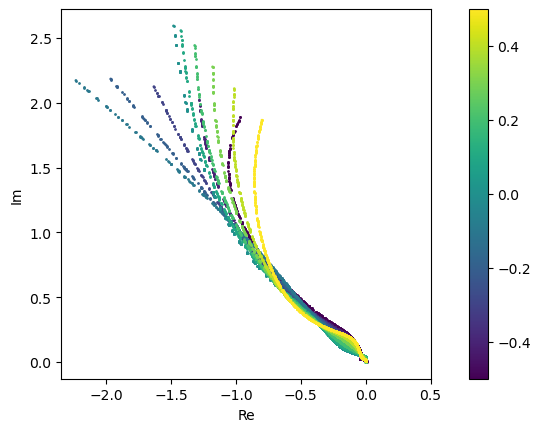

In [15]:
#Parameters to set
gmin = 0; gmax = 2; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
n_repeat = 2
thickness = 20
theta = np.linspace(0, 2*np.pi, 100)
cmap = plt.get_cmap("viridis")
cut_factor = 0.01
krange = np.linspace(gmin+cut_factor, gmax, length)
tilt_range = np.arange(-0.5, 0.6, 0.1)
coeff_rec = []
peak_rec = []
real_peak = []
original_peak = []
diff_rec = []
#Generate isolated structure
for tilt_angle in tqdm(tilt_range):
    structure = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
    structure.rotate(tilt_angle, "x")
    exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure).array),
                                    gmin, gmax, sampling)
    m, n = exitwave_all.shape
    exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                            (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
    m, n = exitwave.shape
    rx, ry, bg_amp, bg_pha = match_parameters_Bessel(exitwave, sampling, 0.01, 1, method="BFGS")
    #exitwave = exitwave - bg_amp * np.exp(1j*bg_pha)
    exitwave = exitwave - 1
    original_peak.append(exitwave[np.unravel_index(np.argmin(np.abs(exitwave-1)), exitwave.shape)])
    results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                        x0=rx, y0=ry)
    diff_rec.append(np.sqrt(np.mean(np.abs(components-exitwave)**2)))
    fitted = Gaussian_fitting(results, krange, [0.01, 1])
    coeff = np.array(list(fitted.best_values.values()))
    a_re, a_im, b_re, b_im, c_re, c_im = coeff
    recover = Gaussian_function(krange, *coeff)
    #recover = Gaussian_in_focus(krange, a_re, a_im, b_re, c_re, c_im)
    coeff_rec.append(coeff)
    bg = coeff[-2] + 1j*coeff[-1]
    peak = coeff[0] + 1j*coeff[1] + bg
    peak_rec.append(peak)
    x = np.arange(-(m-1)/2, (m+1)/2, 1)*sampling - rx; y = np.arange(-(n-1)/2, (n+1)/2, 1)*sampling - ry
    X, Y = np.meshgrid(x, y); R = np.sqrt(X**2 + Y**2)
    real_peak.append(components[np.unravel_index(np.argmin(R), R.shape)])
    plt.scatter(np.real(components), np.imag(components), color=cmap(tilt_angle+0.5), s=1)
    #plt.scatter(R, np.abs(components), color=cmap(tilt_angle+0.5))
    #plt.plot(np.real(recover), np.imag(recover), color=cmap(tilt_angle+0.5), linewidth=0.2)
    #plt.scatter(np.real(recover), np.imag(recover), marker="^", color=cmap(tilt_angle+0.5), s=1)
    #plt.plot(np.real(results), np.imag(results), color=cmap(tilt_angle+0.5), linewidth=0.2)
    #plt.scatter(np.real(results), np.imag(results), color=cmap(tilt_angle+0.5), s=1)
coeff_rec = np.array(coeff_rec)
peak_rec = np.array(peak_rec)
diff_rec = np.array(diff_rec)
real_peak = np.array(real_peak)
original_peak = np.array(original_peak)
#plt.scatter(np.real(original_peak), np.imag(original_peak), marker="^", c=tilt_range, cmap="viridis", s=10)
#s=plt.scatter(np.real(peak_rec), np.imag(peak_rec), c=tilt_range, cmap="viridis", s=1)
s=plt.scatter(np.real(real_peak), np.imag(real_peak), c=tilt_range, cmap="viridis", s=1)
plt.colorbar(s)
plt.axis("square")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

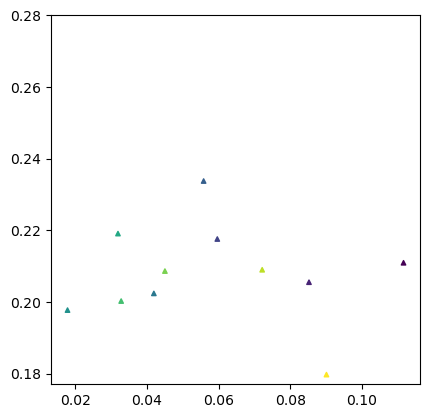

In [10]:
plt.scatter(np.real(original_peak), np.imag(original_peak), marker="^", c=tilt_range, cmap="viridis", s=10)
plt.axis("square")
plt.show()

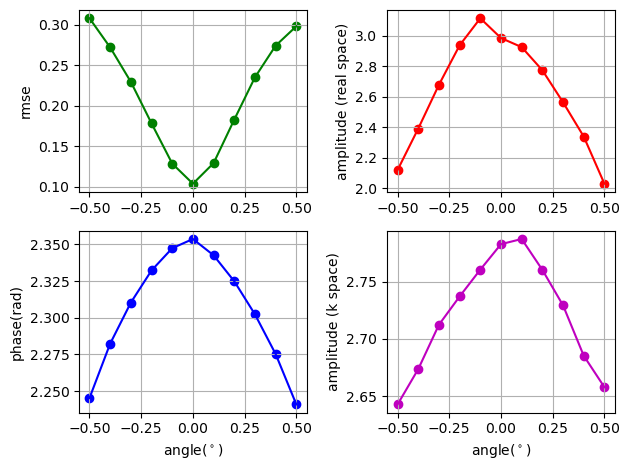

In [232]:
peak_complex=coeff_rec[:,0] + 1j*coeff_rec[:,1]
bg_complex=coeff_rec[:,-2] + 1j*coeff_rec[:,-1]
peak_total=peak_complex + bg_complex
plt.subplot(2, 2, 1)
plt.plot(tilt_range, diff_rec, color='g')
plt.scatter(tilt_range, diff_rec, color='g')
plt.ylabel("rmse")
plt.grid()
plt.subplot(2, 2, 2)
plt.plot(tilt_range, np.abs(real_peak), color='r')
plt.scatter(tilt_range, np.abs(real_peak), color='r')
plt.ylabel("amplitude (real space)")
plt.grid()
plt.subplot(2, 2, 3)
#plt.plot(tilt_range, generate_continious_phase(peak_complex))
plt.plot(tilt_range, generate_continious_phase(peak_total), color='b')
plt.scatter(tilt_range, generate_continious_phase(peak_total), color='b')
plt.xlabel(r"angle($^\circ)$")
plt.ylabel(r"phase(rad)")
plt.grid()
plt.subplot(2, 2, 4)
plt.plot(tilt_range, np.abs(peak_total), color='m')
plt.scatter(tilt_range, np.abs(peak_total), color='m')
plt.xlabel(r"angle($^\circ)$")
plt.ylabel("amplitude (k space)")
plt.grid()
plt.tight_layout()
plt.show()

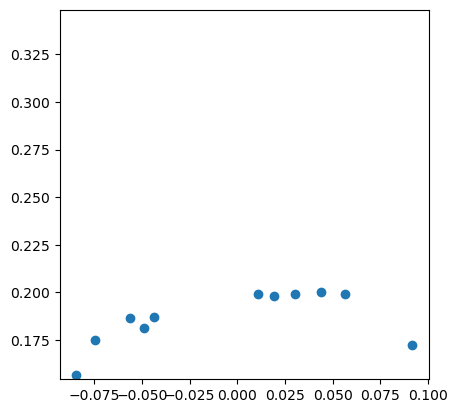

In [14]:
plt.scatter(coeff_rec[:,4], coeff_rec[:,5])
plt.axis('square')
plt.show()

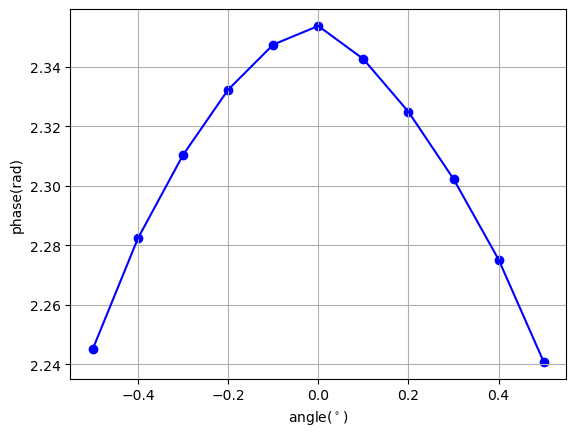

In [205]:
peak_complex=coeff_rec[:,0] + 1j*coeff_rec[:,1]
peak_total=peak_complex + coeff_rec[:,-2] + 1j*coeff_rec[:,-1]
#plt.plot(tilt_range, generate_continious_phase(peak_complex))
plt.plot(tilt_range, generate_continious_phase(peak_total), color='b')
plt.scatter(tilt_range, generate_continious_phase(peak_total), color='b')
plt.xlabel(r"angle($^\circ)$")
plt.ylabel(r"phase(rad)")
plt.grid()
plt.show()

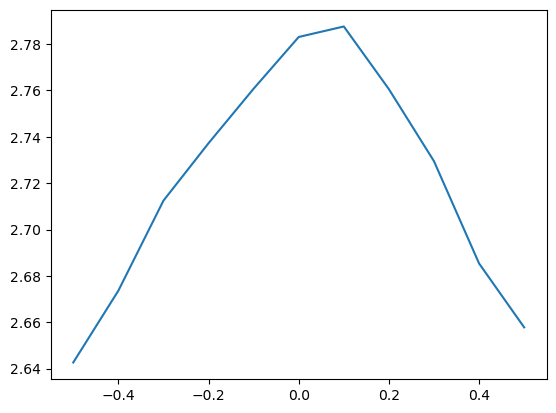

In [198]:
plt.plot(tilt_range, np.abs(peak_total))
plt.show()

In [65]:
rx

-0.24573697692150914

In [66]:
ry

0.06728618387192423